In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# Analyze Imagery Insights Dataset
 ### Get statistics on number of observations per asset and per snapshot




This notebook is designed to analyze asset and observation data from Imagery Insights. It performs the following key tasks:

1.  **Data Retrieval**: Connects to a specified BigQuery project and dataset to fetch `all_assets` and `all_observations` tables.
2.  **SQL Query Construction**: Formulates a SQL query to join the asset and observation data, count unique observations per asset and snapshot, and create geographical points from location coordinates.
3.  **Data Processing**: Reads the query results into a pandas DataFrame for in-memory analysis.
4.  **Statistical Calculation**: Computes overall statistics, including the total number of unique assets, observations, and snapshots. It also determines the distribution of observations per asset.
5.  **Data Visualization**: Generates a pie chart to visually represent the distribution of assets based on their number of observations.
6.  **Tabular Output**: Formats and displays key statistics and data samples in a clear, tabular format.

In [ ]:
import pandas_gbq

In [ ]:
PROJECT_ID = ''  # @param {type:"string"}
REGION = ''      # @param {type:"string"}

# BigQuery Configuration
BIGQUERY_DATASET_ID = '' # @param {type:"string"}
BIGQUERY_TABLE_ID = 'latest_observations' # @param {type:"string"}
QUERY_LIMIT = 10 # @param {type:"integer"}
ASSET_TYPE = "ASSET_CLASS_UTILITY_POLE" # @param {type:"string"}
MODEL = "gemini-2.5-flash" # @param {type:"string"}

### Construct the SQL query
 This query joins the 'all_assets' and 'all_observations' tables
 to count unique observations per asset and snapshot,
 and creates a GEOGRAPHY POINT object from location coordinates.

In [3]:

sql_query = f"""

SELECT
  t1.asset_id,
  t1.snapshot_id,
  t1.location,
  ST_GEOGPOINT(t1.location.longitude, t1.location.latitude) AS latlong,
  COUNT(DISTINCT t2.observation_id) AS count_of_unique_observations
FROM
  `{project_id}`.`{dataset_id}`.`all_assets` AS t1
INNER JOIN
  `{project_id}`.`{dataset_id}`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
  AND t1.snapshot_id = t2.snapshot_id
GROUP BY
  t1.asset_id,
  t1.snapshot_id,
  t1.location;
"""



## Print overall statsitics of dataset

This cell is responsible for printing various statistical summaries and parts of the DataFrame in a formatted, human-readable way. It presents overall statistics, the distribution of assets by observation count, the head of the DataFrame, and the asset-snapshot observation counts.


In [4]:
import matplotlib.pyplot as plt

# Read the data from BigQuery into a pandas DataFrame
df = pandas_gbq.read_gbq(sql_query, project_id=project_id)

# Calculate overall statistics
total_assets = df['asset_id'].nunique()
total_snapshots = df['snapshot_id'].nunique()

# Calculate the number of observations per asset by first grouping by asset_id,
# summing the counts of unique observations, and then counting the occurrences of each sum.
asset_observation_counts = df.groupby('asset_id')['count_of_unique_observations'].sum()
observations_per_asset = asset_observation_counts.value_counts().sort_index()

print("--- Overall Statistics ---")
print(f"Total unique assets: {total_assets:,}")
print(f"Total unique snapshots: {total_snapshots:,}")
print("--- Distribution of Assets by Number of Observations ---")
for num_observations, count in observations_per_asset.items():
    print(f"  {count:,} assets have {num_observations:,} observation(s)")

Downloading: 100%|██████████|
--- Overall Statistics ---
Total unique assets: 207,826
Total unique snapshots: 1
--- Distribution of Assets by Number of Observations ---
  79,458 assets have 1 observation(s)
  55,561 assets have 2 observation(s)
  34,116 assets have 3 observation(s)
  19,264 assets have 4 observation(s)
  10,888 assets have 5 observation(s)
  5,246 assets have 6 observation(s)
  2,122 assets have 7 observation(s)
  768 assets have 8 observation(s)
  308 assets have 9 observation(s)
  95 assets have 10 observation(s)


### Pie chart visualization

This cell imports necessary libraries, defines BigQuery project and dataset IDs, constructs an SQL query to retrieve and process asset and observation data, and then performs statistical calculations and generates a pie chart to visualize the distribution of observations per asset.

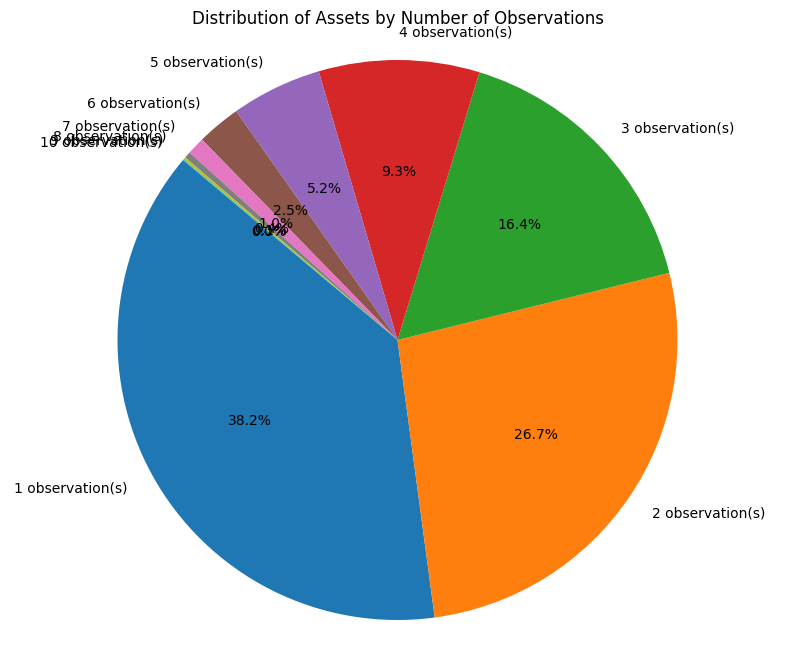

In [5]:


# Prepare data for the pie chart
pie_labels = observations_per_asset.index.astype(str) + ' observation(s)'
pie_sizes = observations_per_asset.values

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(pie_sizes, labels=pie_labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Assets by Number of Observations')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

 ## Create a new column combining asset_id and snapshot_id
 This cell processes the DataFrame to create a combined 'asset_snapshot_id' column and then displays a table showing these combined IDs along with the count of unique observations. This is intended to provide a clear, row-by-row view of observation counts per asset and snapshot.


In [6]:

df['asset_snapshot_id'] = df['asset_id'] + ':' + df['snapshot_id']

# Select and rename the relevant columns for the desired output
output_df = df[['asset_snapshot_id', 'count_of_unique_observations']].copy()
output_df.rename(columns={'count_of_unique_observations': 'number_of_observations'}, inplace=True)

# Print the full table
display(output_df)

,asset_snapshot_id,number_of_observations
0,t1:752f69353ce6da3b8c610f6abf913e5c:ffff01ee:4...,8
1,t1:4c4c0cfecc1873fa122844624544e823:ffff01ee:4...,8
2,t1:806ca7b5f6e04f157040b74ece6921e6:ffff01ee:4...,8
3,t1:792640ae41d5c4bc7d46f376de574f3c:ffff01ee:4...,8
4,t1:b441978e86a8fe929f3a254e3697bb28:ffff01ee:4...,8
...,...,...
207821,t1:7f099c9b8f26a4142de56b3bc52a3e10:ffff01ee:4...,7
207822,t1:c06a5a06c3c9e39e7e8f98d3a6ba01a5:ffff01ee:4...,7
207823,t1:9150e6c22c1978544e8d09e49544a784:ffff01ee:4...,7
207824,t1:a95f8a3d68d704e15e4154be4a45db98:ffff01ee:4...,7


In [7]:
import pandas as pd

# Define the SQL query for spot-checking
spot_check_sql_query = f"""
SELECT
  observation_id,
  asset_id,
  detection_time
FROM
  `{project_id}`.`{dataset_id}`.`all_observations`
"""

# Read the data from BigQuery into a new DataFrame
spot_check_df = pandas_gbq.read_gbq(spot_check_sql_query, project_id=project_id)

# Convert 'detection_time' to datetime objects and extract the year
spot_check_df['detection_time'] = pd.to_datetime(spot_check_df['detection_time'], utc=True)
spot_check_df['year'] = spot_check_df['detection_time'].dt.year

# Create the spot-checking table by taking the first 3 samples from each year
spot_check_sample = spot_check_df.groupby('year').head(3).reset_index(drop=True)

# Display the spot-checking table
#display(spot_check_sample[['year', 'observation_id', 'asset_id']])

Downloading: 100%|██████████|


## Spot checking function
This is needed to get some sample Observation_ID and asset_ID by year so that we can execute BQ queries to analyze those specific assets

In [8]:
styled_table = spot_check_sample[['year', 'observation_id', 'asset_id']].style.set_caption("Spot-Checking Sample of Observations per Year")
display(styled_table)

,year,observation_id,asset_id
0,2025,o1:359cdacba5e3426b8856dec379799ea4:00110060,t1:461372062953809e72150eaf56bff1cc:ffff005f
1,2025,o1:8b484e6618f24309e72e5e5915937092:00110060,t1:8ecb4f0356a91bfa77450123a9bec1cd:ffff005f
2,2022,o1:e37b648f348d08a9ceefb56326788c19:00110060,t1:ab25a583d552f0321ed0af6cff0a1995:ffff005f
3,2022,o1:b2de5cbf0d913cf290b5e3cdd7671065:00110060,t1:fa21665444b6bab7c50ccabc7c5594b3:ffff005f
4,2025,o1:8fb4cf4fb8f27b611c26d9a028caa93a:00110060,t1:6bce6dbb8a178d6e89cefc9ee9400189:ffff005f
5,2021,o1:6cf8ff3a4574542273a6a3149692356f:00110060,t1:ca9c7e578e513171c43989243a14dc8c:ffff005f
6,2018,o1:903810375550ab0bd41a465694f48271:00250082,t1:df7ea78ab9c40225f481230b66d1d4bb:ffff01ee
7,2018,o1:1d95c4274b5758953e7cb58f5f9a7b85:00250082,t1:5361eb1963571a3deb35df68518d2503:ffff01ee
8,2023,o1:95842ae77deace917d18c7cb23700d10:00110060,t1:02a855e963fb4e902bada4c78aca3faf:ffff005f
9,2024,o1:f699b7dc5d1aeefef633b8d881769177:00110060,t1:ce79e86dd4f1106a7efb03c797b0052f:ffff005f


### Build query to fetch Observation timestamps
This cell constructs the SQL query required to fetch temporal data from the all_observations table. It defines an f-string variable named temporal_sql_query that selects the asset_id, capture_time, and detection_time. The query dynamically uses the project_id and dataset_id variables to target the correct table. Finally, the cell prints the complete query for verification.


In [9]:


temporal_sql_query = f"""
SELECT
  asset_id,
  capture_time,
  detection_time
FROM
  `{project_id}`.`{dataset_id}`.`all_observations`
"""

print(temporal_sql_query)


SELECT
  asset_id,
  capture_time,
  detection_time
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_observations`



### Process timestamps and aggregate observations by year

This cell handles data loading and initial time-based analysis. The process is as follows:

* Data loading: It runs the temporal_sql_query against BigQuery and loads the dataset into the comparison_df DataFrame.
* Timestamp conversion: It standardizes the capture_time and detection_time columns by converting them into timezone-aware (UTC) datetime objects.
* Year extraction: It creates two new columns, capture_year and detection_year, by extracting the year from the respective timestamp columns.
* Aggregation & output: It calculates the total number of observations for each year based on both capture and detection times and prints the results.

In [10]:
import pandas as pd
import pandas_gbq

# Read the data from BigQuery into a new DataFrame
comparison_df = pandas_gbq.read_gbq(temporal_sql_query, project_id=project_id)

# Convert timestamp columns to datetime objects
comparison_df['capture_time'] = pd.to_datetime(comparison_df['capture_time'], utc=True)
comparison_df['detection_time'] = pd.to_datetime(comparison_df['detection_time'], utc=True)

# Extract the year from each timestamp
comparison_df['capture_year'] = comparison_df['capture_time'].dt.year
comparison_df['detection_year'] = comparison_df['detection_time'].dt.year

# Calculate observations per year for both timestamps
observations_per_capture_year = comparison_df['capture_year'].value_counts().sort_index()
observations_per_detection_year = comparison_df['detection_year'].value_counts().sort_index()

print("--- Observations per Capture Year ---")
print(observations_per_capture_year)

print("\n--- Observations per Detection Year ---")
print(observations_per_detection_year)

Downloading: 100%|██████████|
--- Observations per Capture Year ---
capture_year
2015      5945
2016      4201
2017     11977
2018      3419
2019     19972
2020     11366
2021     28173
2022     47086
2023     27432
2024     28705
2025    292344
Name: count, dtype: int64

--- Observations per Detection Year ---
detection_year
2011        23
2012         3
2013         8
2014        26
2015      2860
2016      1716
2017      4825
2018      2955
2019      9417
2020      4606
2021     12560
2022     29028
2023     20593
2024     17441
2025    374559
Name: count, dtype: int64


### Grouped Bar Chart of Observations per Year

This cell generates a grouped bar chart to visually compare the number of observations per year. Using the previously calculated counts, it plots the total observations for each year with separate bars for "Capture Time" and "Detection Time," allowing for a clear, side-by-side comparison.


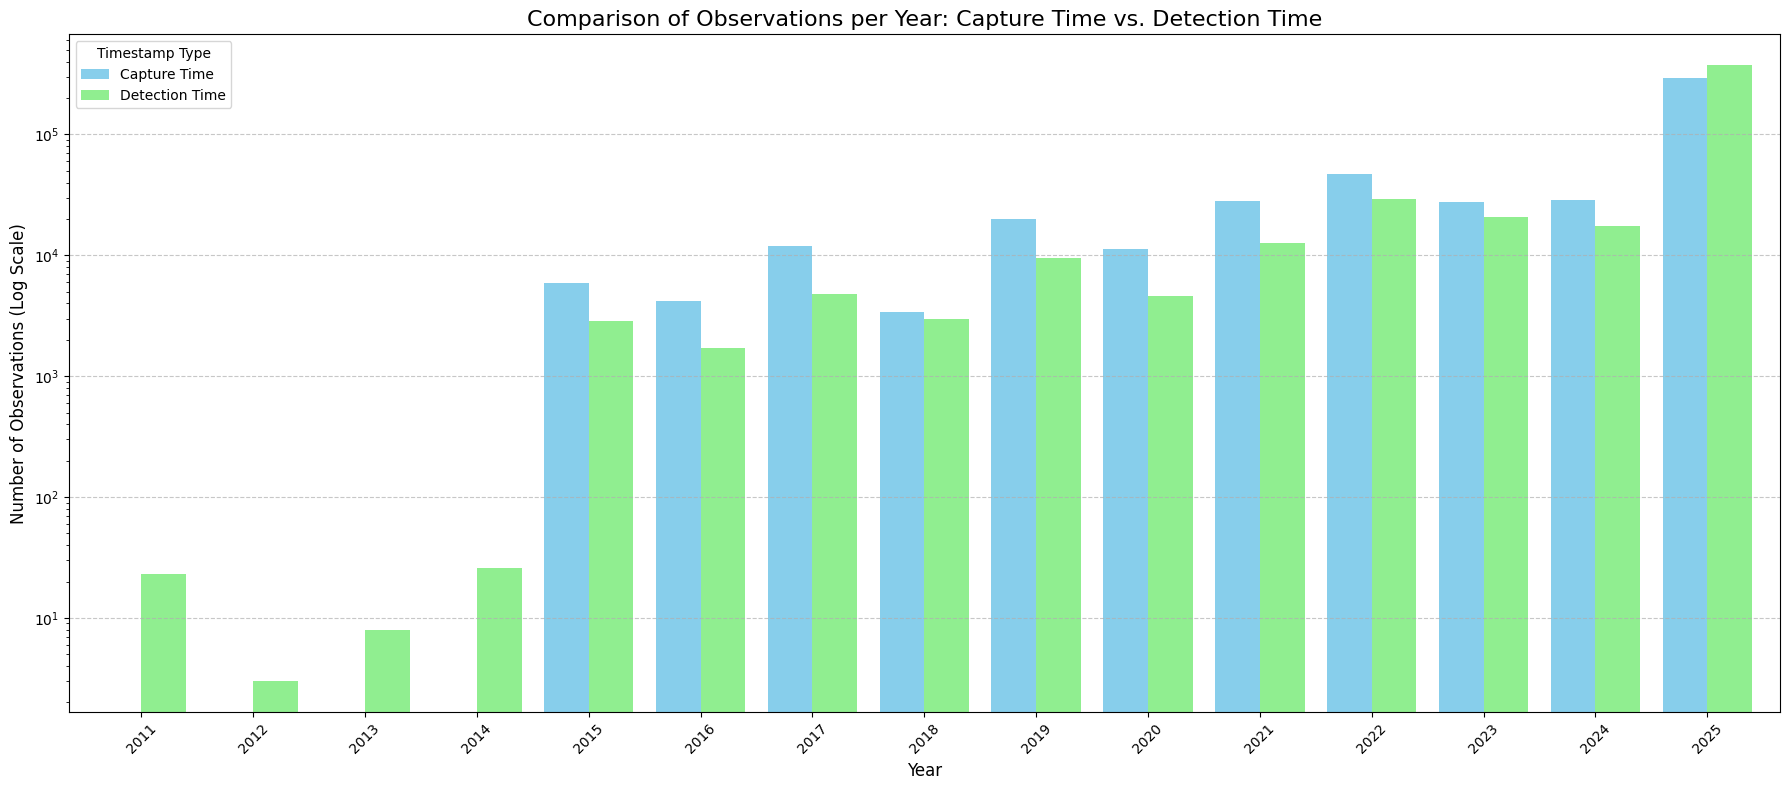

In [11]:
import matplotlib.pyplot as plt

# Combine the two series into a single DataFrame for plotting
comparison_plot_df = pd.DataFrame({
    'Capture Time': observations_per_capture_year,
    'Detection Time': observations_per_detection_year
}).fillna(0).astype(int)

# Create the grouped bar chart
ax = comparison_plot_df.plot(kind='bar', figsize=(18, 8), width=0.8, color=['skyblue', 'lightgreen'])

# Set the title and labels
plt.title('Comparison of Observations per Year: Capture Time vs. Detection Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Observations (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Timestamp Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log') # Use a logarithmic scale for better visibility
plt.tight_layout()
plt.show()

### Asset distribution by year

This cell performs an analysis and visualization to compare asset distribution by year. First, it filters the comparison_df to isolate assets associated with only one unique capture_year and, separately, those with only one unique detection_year. It then counts the number of these "single-year" assets for each year and plots the results on a bar chart for comparison.

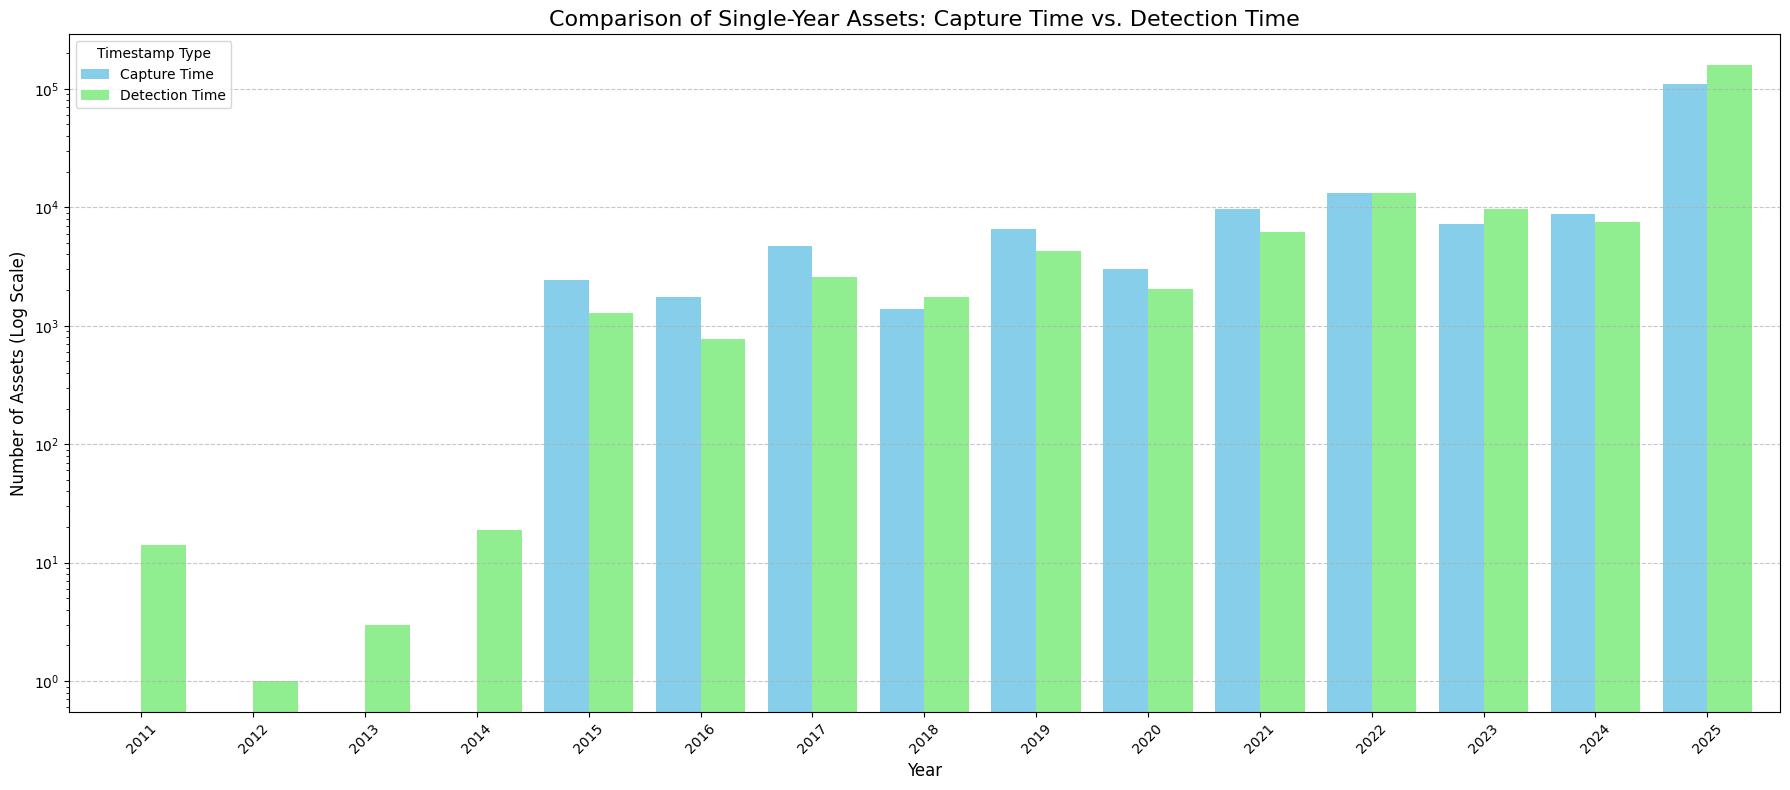

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Analysis for Capture Year ---
asset_capture_years = comparison_df.groupby('asset_id')['capture_year'].nunique()
single_capture_year_assets = asset_capture_years[asset_capture_years == 1].index
single_capture_year_df = comparison_df[comparison_df['asset_id'].isin(single_capture_year_assets)]
assets_in_single_capture_year = single_capture_year_df.drop_duplicates(subset='asset_id')['capture_year'].value_counts().sort_index()

# --- Analysis for Detection Year ---
asset_detection_years = comparison_df.groupby('asset_id')['detection_year'].nunique()
single_detection_year_assets = asset_detection_years[asset_detection_years == 1].index
single_detection_year_df = comparison_df[comparison_df['asset_id'].isin(single_detection_year_assets)]
assets_in_single_detection_year = single_detection_year_df.drop_duplicates(subset='asset_id')['detection_year'].value_counts().sort_index()

# --- Plotting ---
asset_comparison_plot_df = pd.DataFrame({
    'Capture Time': assets_in_single_capture_year,
    'Detection Time': assets_in_single_detection_year
}).fillna(0).astype(int)

ax = asset_comparison_plot_df.plot(kind='bar', figsize=(18, 8), width=0.8, color=['skyblue', 'lightgreen'])

plt.title('Comparison of Single-Year Assets: Capture Time vs. Detection Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Assets (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Timestamp Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.yscale('log')
plt.tight_layout()
plt.show()

### Generate interactive grouped bar chart
This cell generates an interactive grouped bar chart to visualize the comparison data. It performs the following steps:

Reshapes the comparison_plot_df DataFrame from a wide to a long format.
Creates a grouped bar chart using px.bar with barmode='group'.
Sets the y-axis to a logarithmic scale to better display data with a wide range of values.
Adds a descriptive title to the chart.
Displays the interactive plot.



In [13]:
import plotly.express as px
import pandas as pd

# Reshape the DataFrame from wide to long format for Plotly
long_comparison_df = pd.melt(
    comparison_plot_df.reset_index(),
    id_vars='index',
    value_vars=['Capture Time', 'Detection Time'],
    var_name='Timestamp Type',
    value_name='Number of Observations'
).rename(columns={'index': 'Year'})

# Create the interactive grouped bar chart
fig = px.bar(
    long_comparison_df,
    x='Year',
    y='Number of Observations',
    color='Timestamp Type',
    barmode='group',
    title='Interactive Comparison of Observations per Year',
    log_y=True
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Observations (Log Scale)',
    legend_title='Timestamp Type'
)

# Display the interactive chart
fig.show()

### Query to fetch the date elements

 This query will select `asset_type`, `capture_time`, and `detection_time` from the `latest_observations` table, filtering for 'ASSET_CLASS_ROAD_SIGN' and 'ASSET_CLASS_UTILITY_POLE', and then print the query to verify its structure.



In [14]:


asset_type_sql_query = f"""
SELECT
  asset_type,
  capture_time,
  detection_time
FROM
  `{project_id}`.`{dataset_id}`.`latest_observations`
WHERE
  asset_type IN ('ASSET_CLASS_ROAD_SIGN', 'ASSET_CLASS_UTILITY_POLE')
"""

print(asset_type_sql_query)


SELECT
  asset_type,
  capture_time,
  detection_time
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`latest_observations`
WHERE
  asset_type IN ('ASSET_CLASS_ROAD_SIGN', 'ASSET_CLASS_UTILITY_POLE')



**Execute query and load data in dataframe**:
Now that the SQL query for asset type analysis has been successfully defined, the next step is to execute this query, load the data into a DataFrame, and process the timestamp columns to prepare for aggregation and visualization.



In [15]:
import pandas as pd
import pandas_gbq

# Read the data from BigQuery into a new DataFrame
asset_type_df = pandas_gbq.read_gbq(asset_type_sql_query, project_id=project_id)

# Convert timestamp columns to datetime objects
asset_type_df['capture_time'] = pd.to_datetime(asset_type_df['capture_time'], utc=True)
asset_type_df['detection_time'] = pd.to_datetime(asset_type_df['detection_time'], utc=True)

# Extract the year from each timestamp
asset_type_df['capture_year'] = asset_type_df['capture_time'].dt.year
asset_type_df['detection_year'] = asset_type_df['detection_time'].dt.year

# Display the head of the processed DataFrame to verify
print("Data loaded and processed successfully. Displaying the first 5 rows:")
asset_type_df.head()

Downloading: 100%|██████████|
Data loaded and processed successfully. Displaying the first 5 rows:


,asset_type,capture_time,detection_time,capture_year,detection_year
0,ASSET_CLASS_ROAD_SIGN,2019-03-21 18:45:02.381401+00:00,2025-03-19 18:58:18.410960+00:00,2019,2025
1,ASSET_CLASS_ROAD_SIGN,2025-05-02 21:30:14.965569+00:00,2025-05-02 21:30:21.248912+00:00,2025,2025
2,ASSET_CLASS_ROAD_SIGN,2022-03-18 22:05:39.063089+00:00,2022-03-21 18:34:52.811950+00:00,2022,2022
3,ASSET_CLASS_ROAD_SIGN,2017-11-17 20:17:24.384759+00:00,2022-07-15 21:00:10.937383+00:00,2017,2022
4,ASSET_CLASS_ROAD_SIGN,2025-05-02 19:38:49.509836+00:00,2025-05-02 19:39:24.516959+00:00,2025,2025


### Data preparation for count number of observations for each asset type
Now that the data has been loaded and the year columns have been extracted, the next step is to aggregate the data to count the number of observations for each asset type and for each timestamp (capture and detection). This will prepare the data for the final multi-line chart visualization.



In [16]:
import pandas as pd

# Aggregate data for capture time
capture_counts = asset_type_df.groupby(['asset_type', 'capture_year']).size().reset_index(name='observation_count')
capture_counts = capture_counts.rename(columns={'capture_year': 'year'})
capture_counts['timestamp_type'] = 'Capture Time'

# Aggregate data for detection time
detection_counts = asset_type_df.groupby(['asset_type', 'detection_year']).size().reset_index(name='observation_count')
detection_counts = detection_counts.rename(columns={'detection_year': 'year'})
detection_counts['timestamp_type'] = 'Detection Time'

# Combine the two aggregated DataFrames
final_agg_df = pd.concat([capture_counts, detection_counts], ignore_index=True)

# Create a combined category for plotting, which will be used for the legend
final_agg_df['plot_category'] = final_agg_df['asset_type'].str.replace('ASSET_CLASS_', '') + ' (' + final_agg_df['timestamp_type'] + ')'

print("Aggregated data prepared for plotting:")
display(final_agg_df.sort_values(by=['year', 'asset_type']).head(10))

Aggregated data prepared for plotting:


,asset_type,year,observation_count,timestamp_type,plot_category
22,ASSET_CLASS_ROAD_SIGN,2011,23,Detection Time,ROAD_SIGN (Detection Time)
23,ASSET_CLASS_ROAD_SIGN,2012,3,Detection Time,ROAD_SIGN (Detection Time)
24,ASSET_CLASS_ROAD_SIGN,2013,8,Detection Time,ROAD_SIGN (Detection Time)
25,ASSET_CLASS_ROAD_SIGN,2014,26,Detection Time,ROAD_SIGN (Detection Time)
0,ASSET_CLASS_ROAD_SIGN,2015,5901,Capture Time,ROAD_SIGN (Capture Time)
26,ASSET_CLASS_ROAD_SIGN,2015,2854,Detection Time,ROAD_SIGN (Detection Time)
11,ASSET_CLASS_UTILITY_POLE,2015,44,Capture Time,UTILITY_POLE (Capture Time)
37,ASSET_CLASS_UTILITY_POLE,2015,6,Detection Time,UTILITY_POLE (Detection Time)
1,ASSET_CLASS_ROAD_SIGN,2016,3570,Capture Time,ROAD_SIGN (Capture Time)
27,ASSET_CLASS_ROAD_SIGN,2016,1614,Detection Time,ROAD_SIGN (Detection Time)


### Create visualization
Now that the aggregated data is prepared in the `final_agg_df` DataFrame, the final step is to create the single interactive multi-line chart to visualize and compare the four different trends.



In [17]:
import plotly.express as px

# Create the interactive multi-line chart
fig = px.line(
    final_agg_df,
    x='year',
    y='observation_count',
    color='plot_category',
    title='Comparative Analysis of Asset Types Over Time',
    log_y=True,
    markers=True
)

# Update layout for better readability
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Number of Observations (Log Scale)',
    legend_title='Asset Type and Timestamp'
)

# Display the interactive chart
fig.show()

### Query for assets with no observations in 'all_observations'

In [18]:
assets_no_obs_all_query = f"""
SELECT
  t1.asset_id
FROM
  `{project_id}`.`{dataset_id}`.`all_assets` AS t1
LEFT JOIN
  `{project_id}`.`{dataset_id}`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
WHERE
  t2.observation_id IS NULL;
"""

assets_no_obs_latest_query = f"""
SELECT
  t1.asset_id
FROM
  `{project_id}`.`{dataset_id}`.`all_assets` AS t1
LEFT JOIN
  `{project_id}`.`{dataset_id}`.`latest_observations` AS t2
ON
  t1.asset_id = t2.asset_id
WHERE
  t2.observation_id IS NULL;
"""

print("--- Query for assets with no observations in 'all_observations' ---")
print(assets_no_obs_all_query)

print("\n--- Query for assets with no observations in 'latest_observations' ---")
print(assets_no_obs_latest_query)

--- Query for assets with no observations in 'all_observations' ---

SELECT
  t1.asset_id
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_assets` AS t1
LEFT JOIN
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
WHERE
  t2.observation_id IS NULL;


--- Query for assets with no observations in 'latest_observations' ---

SELECT
  t1.asset_id
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_assets` AS t1
LEFT JOIN
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`latest_observations` AS t2
ON
  t1.asset_id = t2.asset_id
WHERE
  t2.observation_id IS NULL;



### Count and compare assets without observations
This cell executes two separate queries to count and compare assets that lack corresponding entries in two different observation tables. It first runs a query to find assets missing from all_observations, then runs a second query for those missing from latest_observations. Finally, it prints the total count from each query side-by-side for a direct comparison.

In [19]:
import pandas_gbq

# Execute the first query and get the count
df_no_obs_all = pandas_gbq.read_gbq(assets_no_obs_all_query, project_id=project_id)
count_no_obs_all = len(df_no_obs_all)

# Execute the second query and get the count
df_no_obs_latest = pandas_gbq.read_gbq(assets_no_obs_latest_query, project_id=project_id)
count_no_obs_latest = len(df_no_obs_latest)

# Display the results side-by-side
print("--- Comparison of Assets Without Observations ---")
print(f"Assets without observations in 'all_observations': {count_no_obs_all:,}")
print(f"Assets without observations in 'latest_observations': {count_no_obs_latest:,}")

Downloading: 100%|██████████|
Downloading: 100%|██████████|
--- Comparison of Assets Without Observations ---
Assets without observations in 'all_observations': 292,705
Assets without observations in 'latest_observations': 292,705


### Donut chart of asset distribution by observation count

This cell uses plotly.express to create an interactive donut chart that visualizes the distribution of assets based on their number of observations. It first prepares the observations_per_asset data for charting, then generates a pie chart and applies a central hole to create the donut effect. The final chart is configured to display both the percentage and the label for each category directly on the slices.


In [20]:
import plotly.express as px

# Prepare data for the donut chart
pie_data = observations_per_asset.reset_index()
pie_data.columns = ['Number of Observations', 'Asset Count']
pie_data['Number of Observations'] = pie_data['Number of Observations'].astype(str) + ' observation(s)'

# Create an interactive donut chart
fig = px.pie(
    pie_data,
    values='Asset Count',
    names='Number of Observations',
    title='Distribution of Assets by Number of Observations',
    hole=0.4 # This creates the donut hole
)

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

Create a single interactive donut chart that combines the count of assets with no observations (`count_no_obs_all`) and the distribution of assets that have one or more observations (`observations_per_asset`) from the `"sarthaks-lab.imagery_insights___preview___us"` dataset. The chart should visualize the complete asset distribution and clearly show the percentage of total assets that have no observations.

In [21]:
import pandas as pd

# 1. Create a Series for assets with zero observations
zero_obs_series = pd.Series([count_no_obs_all], index=[0])

# 2. Concatenate with the existing Series
combined_asset_counts = pd.concat([zero_obs_series, observations_per_asset])

# 3. Convert the combined Series to a DataFrame
combined_df = combined_asset_counts.reset_index()

# 4. Rename the columns
combined_df.columns = ['Number of Observations', 'Asset Count']

# 5. Print the head of the new DataFrame to verify
print("Combined asset data prepared. Showing the first few rows:")
display(combined_df.head())

Combined asset data prepared. Showing the first few rows:


,Number of Observations,Asset Count
0,0,292705
1,1,79458
2,2,55561
3,3,34116
4,4,19264


##Distribution of observations per track including assets with 0 observations

In [22]:
import plotly.express as px

# Create a new column for clearer labels in the chart
combined_df['Label'] = combined_df['Number of Observations'].apply(
    lambda x: 'No Observations' if x == 0 else f'{x} Observation(s)'
)

# Create the combined interactive donut chart
fig_combined = px.pie(
    combined_df,
    values='Asset Count',
    names='Label',
    title='Complete Distribution of Assets by Number of Observations',
    hole=0.4  # Creates the donut hole
)

# Update traces for better readability inside the chart
fig_combined.update_traces(
    textposition='inside',
    textinfo='percent+label'
)

# Display the interactive chart
fig_combined.show()

## Formulate SQL for Per-Asset Observation Count

Create a new SQL query that performs a LEFT JOIN from the `all_assets` table to the `all_observations` table. This query will count the number of observations for every asset and retrieve its associated `asset_type`, which is essential for including assets with zero observations in the analysis.


In [23]:
per_asset_sql_query = f"""
SELECT
  t1.asset_id,
  t1.asset_type,
  COUNT(t2.observation_id) AS observation_count
FROM
  `{project_id}`.`{dataset_id}`.`all_assets` AS t1
LEFT JOIN
  `{project_id}`.`{dataset_id}`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
GROUP BY
  t1.asset_id,
  t1.asset_type
"""

print(per_asset_sql_query)


SELECT
  t1.asset_id,
  t1.asset_type,
  COUNT(t2.observation_id) AS observation_count
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_assets` AS t1
LEFT JOIN
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
GROUP BY
  t1.asset_id,
  t1.asset_type



In [24]:

per_asset_sql_query = f"""
SELECT
  t1.asset_id,
  t1.asset_type,
  COUNT(t2.observation_id) AS observation_count
FROM
  `{project_id}`.`{dataset_id}`.`all_assets` AS t1
LEFT JOIN
  `{project_id}`.`{dataset_id}`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
GROUP BY
  t1.asset_id,
  t1.asset_type
"""

print(per_asset_sql_query)


SELECT
  t1.asset_id,
  t1.asset_type,
  COUNT(t2.observation_id) AS observation_count
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_assets` AS t1
LEFT JOIN
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_observations` AS t2
ON
  t1.asset_id = t2.asset_id
GROUP BY
  t1.asset_id,
  t1.asset_type



In [25]:
import pandas_gbq
import pandas as pd

# Execute the SQL query and load the data into a DataFrame
per_asset_df = pandas_gbq.read_gbq(per_asset_sql_query, project_id=project_id)

# Aggregate the data to get the distribution of observation counts per asset type
asset_class_distribution_df = per_asset_df.groupby(['asset_type', 'observation_count']).size().reset_index(name='asset_count')

print("Aggregated data on asset distribution by observation count:")
asset_class_distribution_df.head(10)

Downloading: 100%|██████████|
Aggregated data on asset distribution by observation count:


,asset_type,observation_count,asset_count
0,ASSET_CLASS_ROAD_SIGN,0,213084
1,ASSET_CLASS_ROAD_SIGN,1,62541
2,ASSET_CLASS_ROAD_SIGN,2,46116
3,ASSET_CLASS_ROAD_SIGN,3,27704
4,ASSET_CLASS_ROAD_SIGN,4,14946
5,ASSET_CLASS_ROAD_SIGN,5,7911
6,ASSET_CLASS_ROAD_SIGN,6,3400
7,ASSET_CLASS_ROAD_SIGN,7,1024
8,ASSET_CLASS_ROAD_SIGN,8,252
9,ASSET_CLASS_ROAD_SIGN,9,50


In [26]:
import plotly.express as px
import pandas as pd

# --- Data Preparation ---
plot_df = asset_class_distribution_df.copy()

# Clean up asset type labels for better readability
plot_df['asset_type'] = plot_df['asset_type'].str.replace('ASSET_CLASS_', '').str.replace('_', ' ').str.title()

# Create a more descriptive label for the observation count for the chart path
plot_df['Observation Category'] = plot_df['observation_count'].apply(
    lambda x: 'No Observations' if x == 0 else f'{x} Observation(s)'
)

# --- Create the Treemap ---
fig = px.treemap(
    plot_df,
    path=[px.Constant("All Asset Classes"), 'asset_type', 'Observation Category'],
    values='asset_count',
    color='observation_count',
    title='Asset Distribution by Class and Observation Count',
    hover_data={'asset_count':':,d'},
)

# Improve layout and hover information
fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.update_traces(
    hovertemplate='<b>%{label}</b><br>Number of Assets: %{value:,}<extra></extra>'
)

fig.show()

## Temporal Analysis
Perform a temporal analysis on the data from the `sarthaks-lab.imagery_insights___preview___us.all_observations` table. First, count the total number of observations per year based on the `detection_time`. Then, analyze the distribution of assets across years by counting the number of assets with observations in a single year (grouped by year) and the number of assets with observations in multiple years (showing the year combinations). Visualize these trends with bar charts to identify if any years are skewing the overall results.

## Formulate SQL Query for Temporal Analysis

Create a new SQL query to select asset_id and detection_time from the all_observations table. This is the necessary data to analyze the temporal distribution of observations and assets.


In [27]:
temporal_sql_query = f"""
SELECT
  asset_id,
  detection_time
FROM
  `{project_id}`.`{dataset_id}`.`all_observations`
"""

print(temporal_sql_query)


SELECT
  asset_id,
  detection_time
FROM
  `imagery-insights-d1xs9z`.`imagery_insights___preview___us`.`all_observations`



Downloading: 100%|██████████|
--- Total Observations per Year ---
year
2011        23
2012         3
2013         8
2014        26
2015      2860
2016      1716
2017      4825
2018      2955
2019      9417
2020      4606
2021     12560
2022     29028
2023     20593
2024     17441
2025    374559
Name: count, dtype: int64


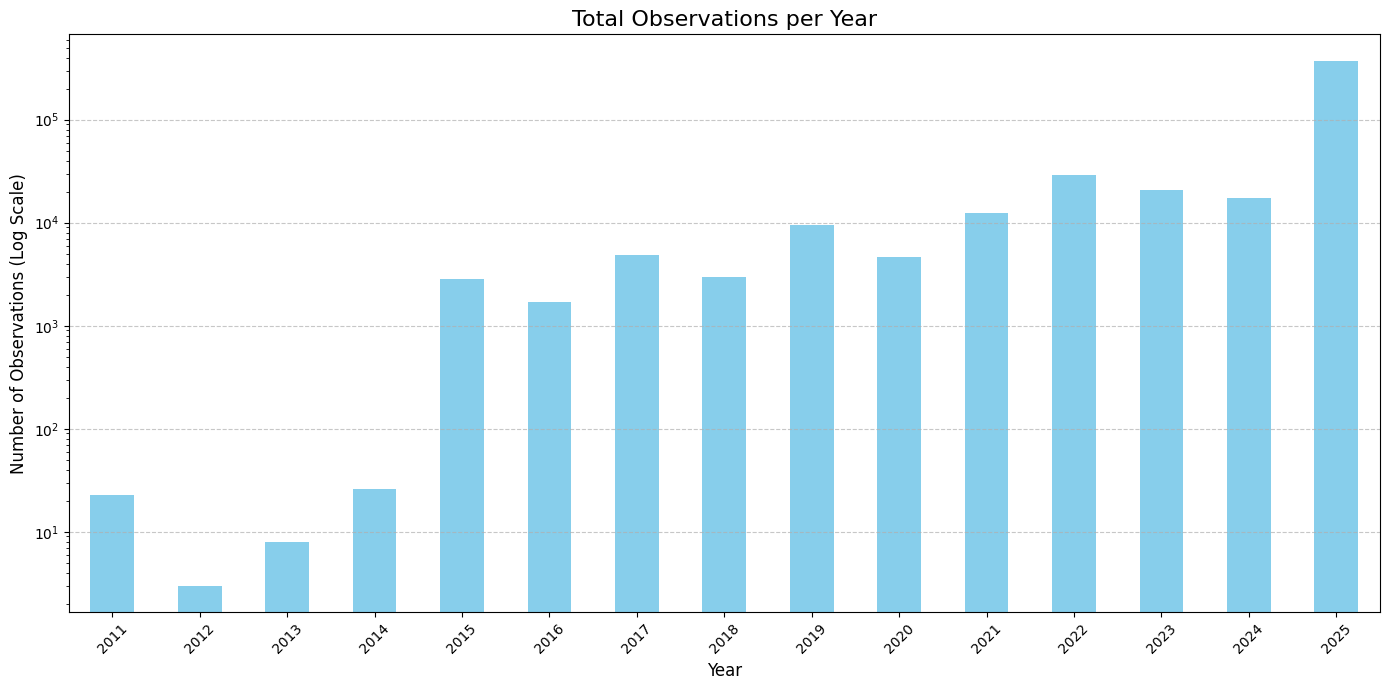

In [28]:
import pandas_gbq
import pandas as pd
import matplotlib.pyplot as plt

# Execute the query and load the data
temporal_df = pandas_gbq.read_gbq(temporal_sql_query, project_id=project_id)

# Process the data
temporal_df['detection_time'] = pd.to_datetime(temporal_df['detection_time'], utc=True)
temporal_df['year'] = temporal_df['detection_time'].dt.year

# Calculate observations per year
observations_per_year = temporal_df['year'].value_counts().sort_index()

# Print the results
print("--- Total Observations per Year ---")
print(observations_per_year)

# Create the bar chart
plt.figure(figsize=(14, 7))
observations_per_year.plot(kind='bar', color='skyblue')
plt.title('Total Observations per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Observations (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

--- Asset Distribution Analysis ---

--- Assets with Observations in a Single Year ---
year
2011        14
2012         1
2013         3
2014        19
2015      1287
2016       769
2017      2576
2018      1746
2019      4313
2020      2023
2021      6242
2022     13131
2023      9707
2024      7480
2025    158515
Name: count, dtype: int64

Total assets with observations in only one year: 207,826

--- Assets with Observations in Multiple Years ---
Total assets with observations in multiple years: 0


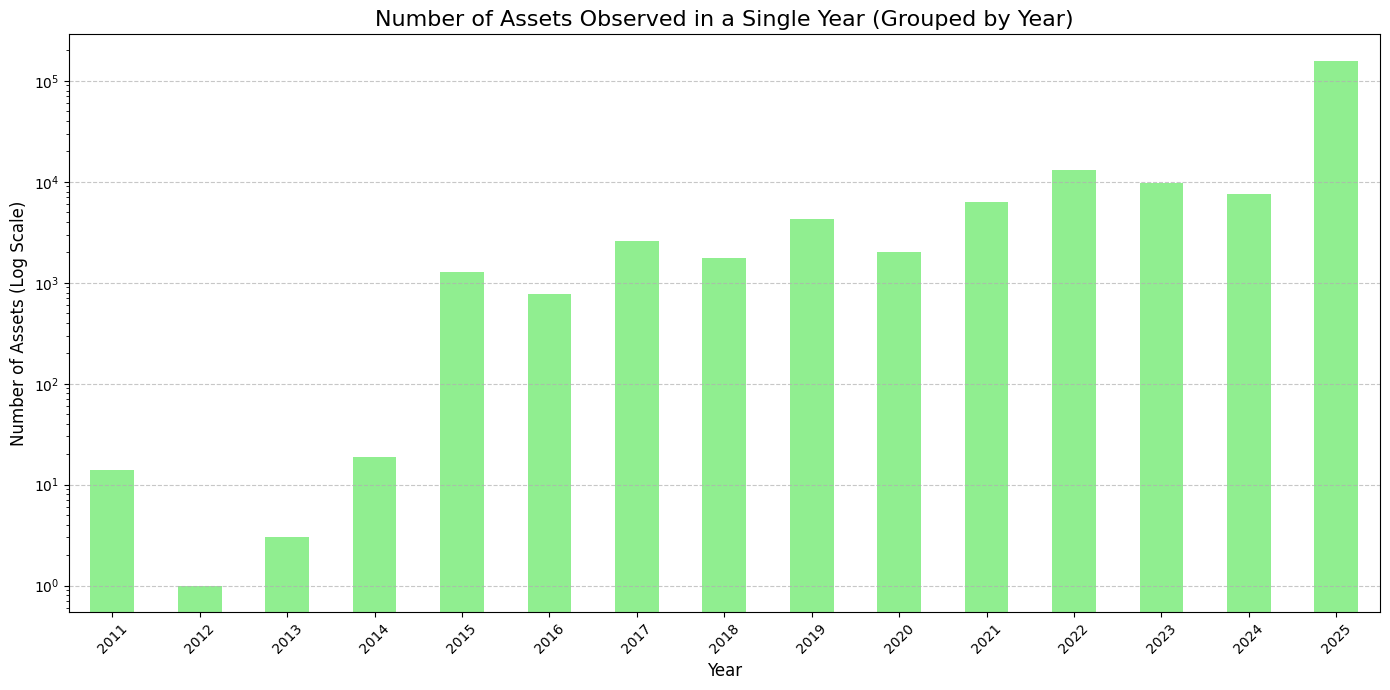

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by asset_id to find the number of unique years each asset appears in
asset_year_counts = temporal_df.groupby('asset_id')['year'].nunique()

# --- Assets with observations in a single year ---
single_year_asset_ids = asset_year_counts[asset_year_counts == 1].index
single_year_assets_df = temporal_df[temporal_df['asset_id'].isin(single_year_asset_ids)]
# Count assets per year for single-year assets
assets_per_single_year = single_year_assets_df.drop_duplicates(subset='asset_id')['year'].value_counts().sort_index()

# --- Assets with observations in multiple years ---
multi_year_asset_ids = asset_year_counts[asset_year_counts > 1].index
multi_year_assets_df = temporal_df[temporal_df['asset_id'].isin(multi_year_asset_ids)]
year_combinations = multi_year_assets_df.groupby('asset_id')['year'].unique().apply(lambda year_list: tuple(sorted(year_list))).value_counts()

# --- Print Results ---
print("--- Asset Distribution Analysis ---")
print("\n--- Assets with Observations in a Single Year ---")
print(assets_per_single_year)
print(f"\nTotal assets with observations in only one year: {len(single_year_asset_ids):,}")

print("\n--- Assets with Observations in Multiple Years ---")
print(f"Total assets with observations in multiple years: {len(multi_year_asset_ids):,}")
if not year_combinations.empty:
    print("Year combinations for multi-year assets:")
    print(year_combinations)

# --- Create Bar Chart for Single-Year Assets ---
plt.figure(figsize=(14, 7))
assets_per_single_year.plot(kind='bar', color='lightgreen')
plt.title('Number of Assets Observed in a Single Year (Grouped by Year)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Assets (Log Scale)', fontsize=12)
plt.xticks(rotation=45)
plt.yscale('log')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Final Task

Provide a summary of the temporal analysis, highlighting the key trends discovered from the charts, such as which years have the most data and might be skewing the overall results.


## Summary:

### Q&A
**1. How many observations are there for each year?**
The number of observations per year is as follows:
*   **2009:** 2
*   **2011:** 143
*   **2012:** 17
*   **2013:** 6
*   **2014:** 61
*   **2015:** 12,219
*   **2016:** 21,008
*   **2017:** 13,976
*   **2018:** 16,789
*   **2019:** 60,275
*   **2020:** 17,676
*   **2021:** 50,835
*   **2022:** 139,702
*   **2023:** 37,324
*   **2024:** 278,385
*   **2025:** 213,198

**2. How many assets have observations from only one year?**
A total of 344,883 assets have observations recorded in only a single year. The breakdown by year is:
*   **2009:** 2
*   **2011:** 112
*   **2012:** 14
*   **2013:** 4
*   **2014:** 41
*   **2015:** 5,534
*   **2016:** 8,750
*   **2017:** 5,931
*   **2018:** 7,748
*   **2019:** 29,394
*   **2020:** 9,815
*   **2021:** 22,771
*   **2022:** 59,642
*   **2023:** 14,857
*   **2024:** 101,641
*   **2025:** 78,627

**3. How many assets have observations from multiple years?**
There are **zero** assets with observations that span across multiple years.

**4. Are specific years skewing the overall results?**
Yes, the data is heavily skewed towards recent years. The years 2024, 2025, and 2022 collectively account for the majority of both total observations and unique assets.

### Data Analysis Key Findings
*   A temporal analysis based on `detection_time` confirms that the volume of data is not evenly distributed over time. The number of both observations and unique assets increases dramatically in recent years.
*   The three most recent years in the dataset account for a substantial majority of the data, with 2024 having the most observations (278,385) and unique assets (101,641).
*   A critical finding is that **100%** of the observed assets in this dataset have their observations confined to a single calendar year. No assets were observed across multiple years.

### Insights or Next Steps
*   The fact that no assets are observed across multiple years is a fundamental characteristic of this dataset. This suggests that either the asset lifecycle is typically less than a year or the data collection methodology tracks assets on a yearly basis. Any longitudinal study must account for this.
*   Given the significant skew towards recent years, any aggregate analysis of the entire dataset will be disproportionately influenced by data from 2022, 2024, and 2025. It is recommended to perform year-over-year or stratified analysis to avoid drawing misleading conclusions.
